<a href="https://colab.research.google.com/github/QuatZo/kickstarter-predictor/blob/master/classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries & dataset

In [19]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import time

from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler

df = pd.read_csv('http://puma.swstats.info/files/kickstarter_with_trends.csv', index_col="ID")
df.columns

Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real', 'tokenized_name', 'trend'],
      dtype='object')

# Clean & prepare data
* Calculate campaign length 
* Delete all incomplete data (like country == N,0")
* Delete all kickstarter projects with different state than 'failed' and 'successful' 
* Cast to numerical types all non-numerical features and drop all empty data
* Use Label Encoding or One-Hot Encoding

In [2]:
df_clean = df.copy()

indexes = df_clean[df_clean['country'] == 'N,0"'].index
df_clean.drop(indexes, inplace=True)
# drop live & undefined states
indexes = df_clean[(df_clean['state'] == 'live') | (df_clean['state'] == 'undefined')].index
df_clean.drop(indexes, inplace=True)

df_clean['campaign_length'] = pd.to_timedelta((pd.to_datetime(df_clean['deadline']) - pd.to_datetime(df_clean['launched'])), unit='days').dt.days
# df_clean = df_clean[(df_clean['usd_goal_real'] >= 10) & (df_clean['campaign_length'] >= 7)] # drop all with lower goal than 10$ and shorter than week

##########################################################
# """ Label Encoding - if you want to run this, just comment lines with quotation marks
for col in ['category', 'main_category', 'currency', 'country']:
  for index, value in enumerate(df_clean[col].unique()):
    df_clean[col].replace(value, index, inplace=True)

df_clean.drop(['tokenized_name'], inplace=True, axis=1)
df_clean.dropna(inplace=True)
# """
##########################################################

###########################################################
""" One-Hot Encoding - if you want to run this, just comment lines with quotation marks
column_transformer = ColumnTransformer([('encoder', OneHotEncoder(), ['category', 'main_category', 'currency', 'country'])], sparse_threshold=0, n_jobs=-1)
onehot = pd.DataFrame(column_transformer.fit_transform(df_clean)).set_index(df_clean.index)
new_cols_encoding = [col.replace('encoder__x0_', '').replace('encoder__x1_', '').replace('encoder__x2_', '').replace('encoder__x3_', '') for col in column_transformer.get_feature_names()]
onehot.columns = new_cols_encoding
df_clean = pd.concat([df_clean, onehot], axis=1)
df_clean.drop(['category', 'main_category', 'currency', 'country', 'tokenized_name'], inplace=True, axis=1)
df_clean = df_clean.loc[:,~df_clean.columns.duplicated()]
"""
##########################################################

df_xd = df_clean[~df_clean['state'].str.contains('successful')].index
df_clean.loc[df_clean['state'].str.contains('successful'), 'state'] = 1
df_clean.loc[df_xd, 'state'] = 0
df_clean['state'] = df_clean['state'].astype(int)


df_clean

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,trend,campaign_length
ID,,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,0,0,0,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,0,0.0,0.0,1533.95,26.526034,58
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,1,1,1,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,1,100.0,2421.0,30000.00,13.684380,59
1000004038,Where is Hank?,1,1,1,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,1,220.0,220.0,45000.00,35.000000,44
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,2,2,1,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,1,1.0,1.0,5000.00,28.000000,29
1000011046,Community Film Project: The Art of Neighborhoo...,3,1,1,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,1,1283.0,1283.0,19500.00,21.800000,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),8,1,1,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,0,1,1,25.0,25.0,50000.00,19.000000,29
999977640,The Tribe,1,1,1,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,0,5,1,155.0,155.0,1500.00,56.000000,26
999986353,Walls of Remedy- New lesbian Romantic Comedy f...,1,1,1,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,0,1,1,20.0,20.0,15000.00,18.000000,45


# Check features correlation
We say features are dependant, if abs(correlation) > .5

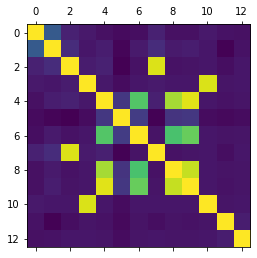

,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,trend,campaign_length
category,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
main_category,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
currency,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.944548,NaN,NaN,NaN,NaN,NaN
goal,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.940032,NaN,NaN
pledged,NaN,NaN,NaN,NaN,1.000000,NaN,0.718115,NaN,0.858192,0.953229,NaN,NaN,NaN
state,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
backers,NaN,NaN,NaN,NaN,0.718115,NaN,1.000000,NaN,0.697815,0.753329,NaN,NaN,NaN
country,NaN,NaN,0.944548,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
usd pledged,NaN,NaN,NaN,NaN,0.858192,NaN,0.697815,NaN,1.000000,0.908090,NaN,NaN,NaN
usd_pledged_real,NaN,NaN,NaN,NaN,0.953229,NaN,0.753329,NaN,0.908090,1.000000,NaN,NaN,NaN


In [0]:
corr = df_clean.corr()

plt.matshow(corr)
plt.show()

corr[(corr > .5) | (corr < -.5)]

# Delete unnecessary features
We delete dupe features (like converted goal value) and the ones that user won't be able to provide, like backers.

In [3]:
df_shortened = df_clean.copy()
df_shortened.drop(['pledged', 'backers', 'usd pledged', 'deadline', 'launched', 'name', 'usd_pledged_real', 'goal', 'currency'], axis=1, inplace=True)
df_shortened

,category,main_category,state,country,usd_goal_real,trend,campaign_length
ID,,,,,,,
1000002330,0,0,0,0,1533.95,26.526034,58
1000003930,1,1,0,1,30000.00,13.684380,59
1000004038,1,1,0,1,45000.00,35.000000,44
1000007540,2,2,0,1,5000.00,28.000000,29
1000011046,3,1,0,1,19500.00,21.800000,55
...,...,...,...,...,...,...,...
999976400,8,1,0,1,50000.00,19.000000,29
999977640,1,1,0,1,1500.00,56.000000,26
999986353,1,1,0,1,15000.00,18.000000,45


# Split data
Split data for training & test set, with 10% being in test set. 30k is enough for testing.

In [4]:
X = df_shortened.drop('state', axis=1)
y = df_shortened['state']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=2137) # 90%:10%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1, random_state=2137) # 81%:9% -> 90%
X_train

,category,main_category,country,usd_goal_real,trend,campaign_length
ID,,,,,,
1942408238,121,6,1,10000.00,10.000000,29
151688513,3,1,0,1680.87,18.200000,29
1202127605,27,11,1,60000.00,33.600000,23
1481031083,49,12,1,40000.00,38.500000,29
1354614493,117,9,2,23266.64,36.488323,59
...,...,...,...,...,...,...
696627033,19,9,1,1500.00,38.000000,40
259775964,46,1,1,5000.00,13.500000,29
2002951756,7,4,0,12945.99,42.000000,29


# Data Over/Undersampling

In [21]:
X_train_cols = X_train.columns


def sample_data(sampler, X_train, y_train, cols, name):
  start = time.time()
  X_train_new, y_train_new = sampler.fit_sample(X_train, y_train)
  X_train_new = pd.DataFrame(X_train_new)
  X_train_new.columns = cols
  print(f"{name} done in {round(time.time() - start, 2)} seconds")

  return {
      'x': X_train_new,
      'y': y_train_new,
  }

sampling_methods = {
    'SMOTE [OVERSAMPLING]': SMOTE(n_jobs=-1, random_state=2137), # Oversampling by using SMOTE
    'SMOTENC [OVERSAMPLING]': SMOTENC([0, 1, 2], n_jobs=-1, random_state=2137), # Oversampling by using SMOTENC - SMOTE for Categorical data
    'BorderlineSMOTE-2 [OVERSAMPLING]': BorderlineSMOTE(n_jobs=-1, random_state=2137,kind='borderline-2'), # Oversampling by using BorderlineSMOTE2  - BorderlineSMOTE2
    'BorderlineSMOTE-1 [OVERSAMPLING]': BorderlineSMOTE(n_jobs=-1, random_state=2137), # Oversampling by using BorderlineSMOTE1  - BorderlineSMOTE1
    'ADASYN [OVERSAMPLING]': ADASYN(random_state=2137, n_jobs=-1), # Oversampling by using ADASYN
    'RandomUnderSampler [UNDERSAMPLING]': RandomUnderSampler(random_state=2137), # Undersampling by using RandomUnderSampler
    'NearMiss v1 [UNDERSAMPLING]': NearMiss(n_jobs=-1, version=1), # Undersampling by using NearMiss v1
    # nearmiss_v2 = NearMiss(n_jobs=-1, version=2), # Undersampling by using NearMiss v2, crashes runtime
    'NearMiss v3 [UNDERSAMPLING]': NearMiss(n_jobs=-1, version=3), # Undersampling by using NearMiss v3
}

train_data = dict()
test_data = dict()
val_data = dict()

for key, val in sampling_methods.items():
  train_data[key] = sample_data(val, X_train, y_train, X_train_cols, key.split(' [')[0])
  test_data[key] = { 'x': X_test, 'y': y_test }
  val_data[key] = { 'x': X_val, 'y': y_val }

for key, val in train_data.items():
  print(key)
  print(pd.Series(val['y']).value_counts())
  print()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SMOTE done in 2.08 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SMOTENC done in 463.18 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


BorderlineSMOTE-2 done in 10.21 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


BorderlineSMOTE-1 done in 12.03 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


ADASYN done in 14.62 seconds
RandomUnderSampler done in 0.08 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NearMiss v1 done in 2.68 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NearMiss v3 done in 8.22 seconds
SMOTE [OVERSAMPLING]
1    192759
0    192759
dtype: int64

SMOTENC [OVERSAMPLING]
1    192759
0    192759
dtype: int64

BorderlineSMOTE-2 [OVERSAMPLING]
1    192759
0    192759
dtype: int64

BorderlineSMOTE-1 [OVERSAMPLING]
1    192759
0    192759
dtype: int64

ADASYN [OVERSAMPLING]
1    198600
0    192759
dtype: int64

RandomUnderSampler [UNDERSAMPLING]
1    108604
0    108604
dtype: int64

NearMiss v1 [UNDERSAMPLING]
1    108604
0    108604
dtype: int64

NearMiss v3 [UNDERSAMPLING]
1    108604
0    108604
dtype: int64



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# (Optional) Delete all irrelevant features
Delete all irrelevant features, but keep AT MAX 5

In [0]:
""" If you want to use this cell, just comment lines with quotation marks at the beginning
logistic = LogisticRegression(C=1, penalty="l2", max_iter=1000).fit(X_train, y_train)
model = SelectFromModel(logistic, prefit=True, max_features=5)

X_new = model.transform(X_train)

selected_features = pd.DataFrame(model.inverse_transform(X_new), index=X_train.index, columns=X_train.columns)
selected_columns = selected_features.columns[selected_features.var() != 0]

X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

selected_features
"""

' If you want to use this cell, just comment lines with quotation marks at the beginning\nlogistic = LogisticRegression(C=1, penalty="l2", max_iter=1000).fit(X_train, y_train)\nmodel = SelectFromModel(logistic, prefit=True, max_features=5)\n\nX_new = model.transform(X_train)\n\nselected_features = pd.DataFrame(model.inverse_transform(X_new), index=X_train.index, columns=X_train.columns)\nselected_columns = selected_features.columns[selected_features.var() != 0]\n\nX_train = X_train[selected_columns]\nX_test = X_test[selected_columns]\n\nselected_features\n'

# Standarization & min-max scaling
Standarization -> mean-std

Min-Max scaling -> min-max

In [0]:
##########################################################
"""min-max normalization: (value - min) / (max - min) - if you want to run this, just comment lines with quotation marks
raise NotImplementedError("Min-Max Scaling hasn't been implemented yet for new data system")
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())
"""
##########################################################

##########################################################
# """mean-std standarization: (sample - mean) / standard_deviation - if you want to run this, just comment lines with quotation marks
def standarize(X_train, X_test, X_val):
  cols = X_train.columns
  indexes_x_train = X_train.index
  indexes_x_test = X_test.index
  indexes_x_val = X_val.index

  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = pd.DataFrame(scaler.transform(X_train)).set_index(indexes_x_train)
  X_test = pd.DataFrame(scaler.transform(X_test)).set_index(indexes_x_test)
  X_val = pd.DataFrame(scaler.transform(X_val)).set_index(indexes_x_val)
  X_train.columns = cols
  X_test.columns = cols
  X_val.columns = cols

  return X_train, X_test, X_val

for key, val in train_data.items():
  train_data[key]['x'], test_data[key]['x'], val_data[key]['x'] = standarize(val['x'], test_data[key]['x'], val_data[key]['x'])
# """
##########################################################

# SVC Classifier
Since it's not a Linear Classifier, 350k rows is too much for this algorithm. It takes roughtly 2 hours to compute with only 55% accuracy. It's still here because it's worth mentioning that we tried it.

In [0]:
# classifier = SVC(gamma='auto', verbose=1, random_state=420)
# classifier.fit(X_train, y_train)
# predict is to predict, score is to get model accuracy
# classifier.score(X_test, y_test)

# Function for all models (except Deep Learning, for now)

In [0]:
def train_model(model, name, X_train, y_train, X_test, y_test, X_val=None, y_val=None):
  start = time.time()
  model.fit(X_train, y_train)
  model_predict = model.predict(X_test)

  print(f"\t{name}")
  print("\t\tScore:", model.score(X_test, y_test))
  print(f"\t\tTraining time: {round(time.time() - start, 2)} seconds")
  print("\t\tConfusion Matrix\n", pd.crosstab(y_test, model_predict))
  print("\t\tClassification Report\n", classification_report(y_test, model_predict))

# SVC Linear Classifier
Same as above, except it's linear and handles huge amount of input data. Takes ~60 seconds to train prediction model. Unless you turn off 'dual' parameter, then 1 second.

In [8]:
for key in train_data.keys():
  classifier_linear = LinearSVC(verbose=1, dual=False, random_state=2137)
  print(key)
  train_model(classifier_linear, "Linear SVC", train_data[key]['x'], train_data[key]['y'], test_data[key]['x'], test_data[key]['y'])

SMOTE [OVERSAMPLING]
[LibLinear]	Linear SVC
		Score: 0.5568994248239532
		Training time: 0.97 seconds
		Confusion Matrix
 col_0      0      1
state              
0      10995  12918
1       3568   9725
		Classification Report
               precision    recall  f1-score   support

           0       0.75      0.46      0.57     23913
           1       0.43      0.73      0.54     13293

    accuracy                           0.56     37206
   macro avg       0.59      0.60      0.56     37206
weighted avg       0.64      0.56      0.56     37206

ADASYN [OVERSAMPLING]
[LibLinear]	Linear SVC
		Score: 0.54644412191582
		Training time: 0.94 seconds
		Confusion Matrix
 col_0      0      1
state              
0      10114  13799
1       3076  10217
		Classification Report
               precision    recall  f1-score   support

           0       0.77      0.42      0.55     23913
           1       0.43      0.77      0.55     13293

    accuracy                           0.55     37206
  

# SVC Linear Search Best Parameters
Script used to find the best parameters for Linear SVC.

In [0]:
parameters_svc = {
    'loss': ['squared_hinge', 'hinge'],
    'tol': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'C': [1, 3, 5, 7, 9],
}

# the best version
svc_brute_force = LinearSVC(verbose=2, dual=False, random_state=2137)
grid_svc = GridSearchCV(svc_brute_force, param_grid=parameters_svc, verbose=5, cv=4)
grid_svc = grid_svc.fit(X_train, y_train)

print("Best parameters for Linear SVC:", grid_svc.best_params_)
print("Best score for above parameters:", grid_svc.best_score_)
print("Accuracy of Linear SVC Model w/ best parameters:", grid_svc.score(X_test, y_test))

# SVC Linear Best Parameters
Best parameters actually gave the same accuracy as default parameters.

Best parameters for Linear SVC: {'C': 3, 'loss': 'squared_hinge', 'tol': 1e-07}

Best score for above parameters: 0.6058348920660341

Accuracy of Linear SVC Model w/ best parameters: 0.6087914077113378

# XGBoost Classifier
Use XGBoost method to train a classification model. It takes ~1s to compute by using GPU, ~67% accuracy (better than LinearSVC).

In [0]:
# hist speeds up computation time 2.5x
# gpu_hist faster 2.5x than hist
# gpu_hist with TPU gives error
# hist with TPU fast like hist
# winner is gpu_hist with GPU
for key in train_data.keys():
  classifier_xgb = xgb.XGBClassifier(tree_method='gpu_hist', n_jobs=-1, seed=2137)
  print(key)
  train_model(classifier_xgb, "XGBoost", train_data[key]['x'], train_data[key]['y'], test_data[key]['x'], test_data[key]['y'])

SMOTE [OVERSAMPLING]
	XGBoost
		Score: 0.6664516475837231
		Training time: 2.7 seconds
		Confusion Matrix
 col_0      0     1
state             
0      16853  7060
1       5350  7943
		Classification Report
               precision    recall  f1-score   support

           0       0.76      0.70      0.73     23913
           1       0.53      0.60      0.56     13293

    accuracy                           0.67     37206
   macro avg       0.64      0.65      0.65     37206
weighted avg       0.68      0.67      0.67     37206

SMOTENC [OVERSAMPLING]
	XGBoost
		Score: 0.6609955383540289
		Training time: 2.84 seconds
		Confusion Matrix
 col_0      0     1
state             
0      16286  7627
1       4986  8307
		Classification Report
               precision    recall  f1-score   support

           0       0.77      0.68      0.72     23913
           1       0.52      0.62      0.57     13293

    accuracy                           0.66     37206
   macro avg       0.64      0.65   

# XGBoost Search Best Parameters
Brute-force this classifier, to find the best parameters.

In [0]:
parameters = {
    'subsample': [.8, .1],
    'max_depth': [3, 6, 10],
    'learning_rate': [.7, .5, .3, 1e-3, 1e-4 , 1e-5],
    'gamma': [0, .5, 1],
    'lambda': [0, .5, 1],
    'aplha': [0, .5, 1],
}

# the best version
xgb_brute_force = xgb.XGBClassifier(verbosity=2, tree_method='gpu_hist', seed=2137)
grid_obj = GridSearchCV(xgb_brute_force, param_grid=parameters, verbose=5, cv=4, n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

print("Best parameters for XGB:", grid_obj.best_params_)
print("Best score for above parameters:", grid_obj.best_score_)
print("Accuracy of XGB Model w/ best parameters:", grid_obj.score(X_test, y_test))

# XGBoost Best Parameters
6% accuracy boost between default & best parameter models

Best parameters for XGB: {'colsample_bytree': 0.8, 'gamma': 0, 'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 6, 'max_leaves': 0, 'num_parallel_tree': 5, 'reg_alpha': 0.001, 'sampling_method': 'uniform', 'subsample': 0.8, 'learning_rate': .3}

Best score for above parameters: 0.7263483962182992

Accuracy of XGB Model w/ best parameters: 6987675398815558

# XGBoost Best Parameters over/under-fitting
Cell to check if model is overfitting, set to 300 iterations.

SMOTE [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 45.43secs
	Average Calculation time: 4.54secs
	Confusion Matrix
 col_0      0     1
state             
0      18885  5028
1       6204  7089
	Recall: [0.7897377995232718, 0.5332881967953058]
	Precision: [0.7527203156761928, 0.5850458034166873]
	F1 Score: [0.7707848659238399, 0.557969303423849]
	Showing last iteration over SMOTE [OVERSAMPLING] model.


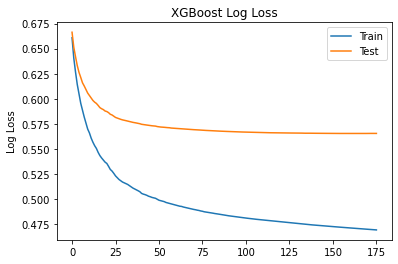

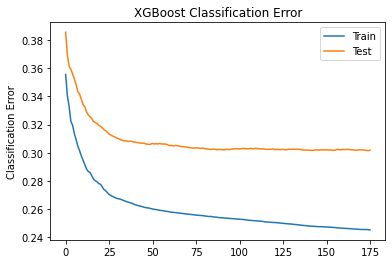



SMOTENC [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 54.27secs
	Average Calculation time: 5.43secs
	Confusion Matrix
 col_0      0     1
state             
0      17795  6118
1       5427  7866
	Recall: [0.74415589846527, 0.5917400135409614]
	Precision: [0.7662991990353974, 0.5625]
	F1 Score: [0.7550652381457515, 0.5767496425559996]
	Showing last iteration over SMOTENC [OVERSAMPLING] model.


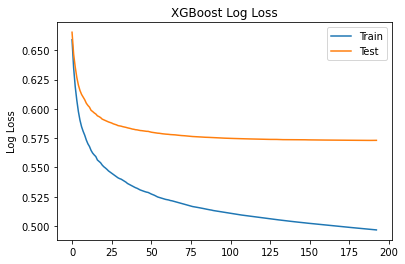

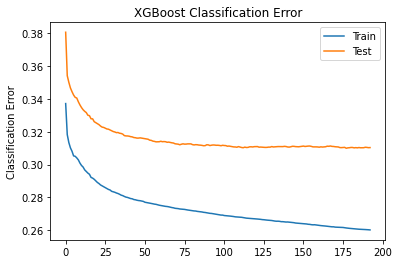



BorderlineSMOTE-2 [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 54.75secs
	Average Calculation time: 5.48secs
	Confusion Matrix
 col_0      0     1
state             
0      19445  4468
1       6674  6619
	Recall: [0.8131560239200435, 0.4979312420070714]
	Precision: [0.7444772005053792, 0.5970055019392081]
	F1 Score: [0.7773025263831148, 0.5429860541427399]
	Showing last iteration over BorderlineSMOTE-2 [OVERSAMPLING] model.


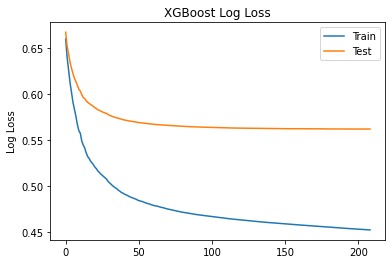

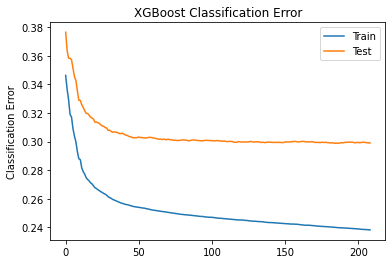



BorderlineSMOTE-1 [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 41.33secs
	Average Calculation time: 4.13secs
	Confusion Matrix
 col_0      0     1
state             
0      18850  5063
1       6179  7114
	Recall: [0.7882741604984737, 0.5351688858797864]
	Precision: [0.7531263734068481, 0.5842161451917549]
	F1 Score: [0.7702995382289242, 0.5586179819395368]
	Showing last iteration over BorderlineSMOTE-1 [OVERSAMPLING] model.


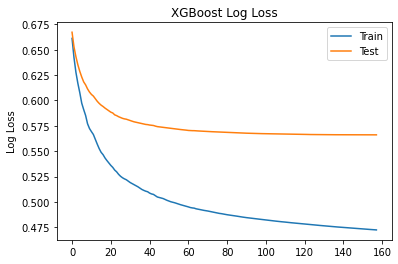

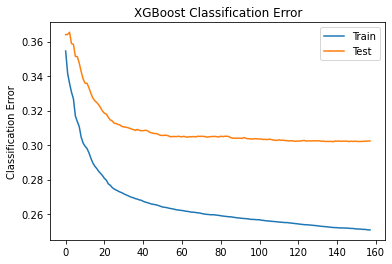



ADASYN [OVERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 51.41secs
	Average Calculation time: 5.14secs
	Confusion Matrix
 col_0      0     1
state             
0      18811  5102
1       6153  7140
	Recall: [0.7866432484422698, 0.5371248025276462]
	Precision: [0.7535250761095978, 0.5832380330011436]
	F1 Score: [0.7697280929680627, 0.5592324260818484]
	Showing last iteration over ADASYN [OVERSAMPLING] model.


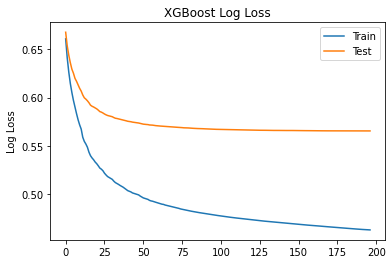

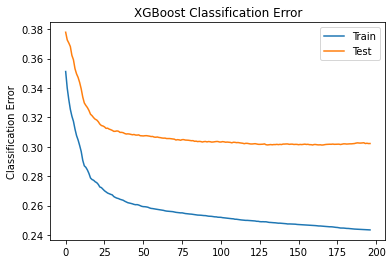



RandomUnderSampler [UNDERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 32.4secs
	Average Calculation time: 3.24secs
	Confusion Matrix
 col_0      0     1
state             
0      15644  8269
1       3957  9336
	Recall: [0.654204825826956, 0.7023245317084179]
	Precision: [0.798122544768124, 0.5303038909400738]
	F1 Score: [0.7190329549110631, 0.6043109586380994]
	Showing last iteration over RandomUnderSampler [UNDERSAMPLING] model.


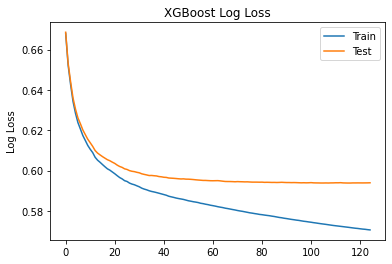

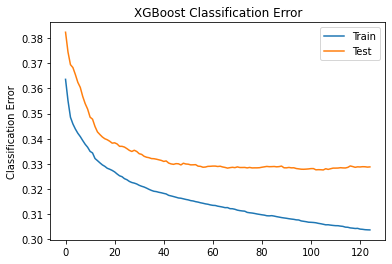



NearMiss v1 [UNDERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 4.47secs
	Average Calculation time: 0.45secs
	Confusion Matrix
 col_0      0      1
state              
0      12496  11417
1       5149   8144
	Recall: [0.5225609501108184, 0.6126532761603851]
	Precision: [0.7081892887503543, 0.4163386329942232]
	F1 Score: [0.6013763896241399, 0.49576916052839837]
	Showing last iteration over NearMiss v1 [UNDERSAMPLING] model.


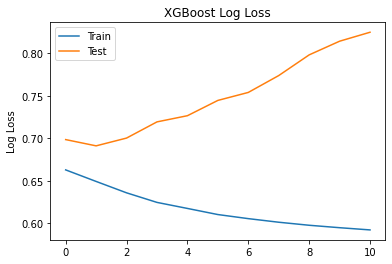

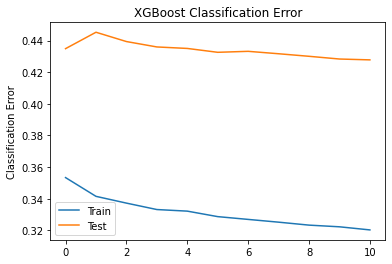



NearMiss v3 [UNDERSAMPLING]
	Working on 1/10
	Done 1/10
	Working on 2/10
	Done 2/10
	Working on 3/10
	Done 3/10
	Working on 4/10
	Done 4/10
	Working on 5/10
	Done 5/10
	Working on 6/10
	Done 6/10
	Working on 7/10
	Done 7/10
	Working on 8/10
	Done 8/10
	Working on 9/10
	Done 9/10
	Working on 10/10
	Done 10/10
	Calculation time: 14.33secs
	Average Calculation time: 1.43secs
	Confusion Matrix
 col_0      0     1
state             
0      16323  7590
1       4790  8503
	Recall: [0.6825994229080417, 0.6396599714135259]
	Precision: [0.7731255624496756, 0.5283663704716336]
	F1 Score: [0.7250477501887798, 0.5787109507928946]
	Showing last iteration over NearMiss v3 [UNDERSAMPLING] model.


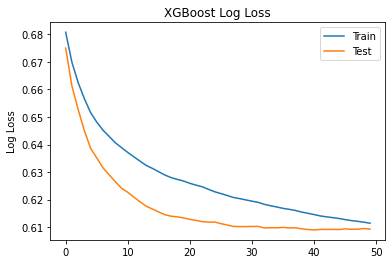

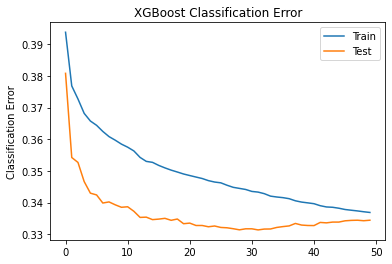

In [24]:
ITERS = 10

for key in train_data.keys():
  xgb_eval_set = [(train_data[key]['x'], train_data[key]['y']), (test_data[key]['x'], test_data[key]['y'])]
  scores = list()
  matrixes = list()
  CLASS_COUNT = 2
  start = time.time()
  print(key)

  for i in range(ITERS):
    print(f"\tWorking on {i + 1}/{ITERS}")
    classifier_xgb_fitting = xgb.XGBClassifier(verbosity=1, tree_method='gpu_hist', n_jobs=-1, colsample_bytree=.8, 
                                            gamma=0, grow_policy='depthwise', learning_rate=.3, max_depth=6, max_leaves=0, 
                                            num_parallel_tree=5, reg_alpha=.001, sampling_method='uniform', subsample=.8, n_estimators=500)

    classifier_xgb_fitting.fit(train_data[key]['x'], train_data[key]['y'], early_stopping_rounds=10, 
                              eval_set=xgb_eval_set, eval_metric=['error', 'logloss'], verbose=False)
    classifier_xgb_fitting_predict = classifier_xgb_fitting.predict(test_data[key]['x'])

    scores.append(classifier_xgb_fitting.score(test_data[key]['x'], test_data[key]['y']))
    matrixes.append(pd.crosstab(test_data[key]['y'], classifier_xgb_fitting_predict))

    print(f"\tDone {i + 1}/{ITERS}")
  
  calc_time = time.time() - start
  print(f"\tCalculation time: {round(calc_time, 2)}secs")
  print(f"\tAverage Calculation time: {round(calc_time / ITERS, 2)}secs")


  avg_matrix = pd.concat(matrixes) 
  avg_matrix_by_row_index = avg_matrix.groupby(avg_matrix.index)
  conf_matrix_means = avg_matrix_by_row_index.mean()

  recall = [conf_matrix_means.at[i%2,i%2] /  (conf_matrix_means.at[i%2,i%2] + conf_matrix_means.at[i%2,(i+1)%2]) for i in range(CLASS_COUNT)]
  precision = [conf_matrix_means.at[i%2,i%2] /  (conf_matrix_means.at[i%2,i%2] + conf_matrix_means.at[(i+1)%2,i%2]) for i in range(CLASS_COUNT)]
  f1score = [2*recall[i]*precision[i]/(recall[i]+precision[i]) for i in range(CLASS_COUNT)]

  print("\tConfusion Matrix\n", conf_matrix_means)
  print("\tRecall:", recall)
  print("\tPrecision:", precision)
  print("\tF1 Score:", f1score)

  # validation_0 - Train Set
  # validation_1 - Test Set

  print(f"\tShowing last iteration over {key} model.")
  # retrieve performance metrics
  results = classifier_xgb_fitting.evals_result()
  epochs = len(results['validation_0']['error'])
  x_axis = range(0, epochs)

  # plot log loss
  fig, ax = plt.subplots()
  ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
  ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
  ax.legend()
  plt.ylabel('Log Loss')
  plt.title('XGBoost Log Loss')
  plt.show()

  # plot classification error
  fig, ax = plt.subplots()
  ax.plot(x_axis, results['validation_0']['error'], label='Train')
  ax.plot(x_axis, results['validation_1']['error'], label='Test')
  ax.legend()
  plt.ylabel('Classification Error')
  plt.title('XGBoost Classification Error')
  plt.show()

  print('\n')

# Dart XGBoost
XGBoost with different booster - 'dart' instead of 'gbtree'. Takes a lot more time to compute with very similar, if not the same accuracy.

In [0]:
for key in train_data.keys():
  classifier_xgb_dart = xgb.XGBClassifier(booster='dart', tree_method='gpu_hist', n_jobs=-1, seed=2137)
  print(key)
  train_model(classifier_xgb_dart, "XGBoost Dart", train_data[key]['x'], train_data[key]['y'], test_data[key]['x'], test_data[key]['y'])

SMOTE [OVERSAMPLING]
	XGBoost Dart
		Score: 0.6664516475837231
		Training time: 23.13 seconds
		Confusion Matrix
 col_0      0     1
state             
0      16853  7060
1       5350  7943
		Classification Report
               precision    recall  f1-score   support

           0       0.76      0.70      0.73     23913
           1       0.53      0.60      0.56     13293

    accuracy                           0.67     37206
   macro avg       0.64      0.65      0.65     37206
weighted avg       0.68      0.67      0.67     37206

SMOTENC [OVERSAMPLING]
	XGBoost Dart
		Score: 0.6609955383540289
		Training time: 23.28 seconds
		Confusion Matrix
 col_0      0     1
state             
0      16286  7627
1       4986  8307
		Classification Report
               precision    recall  f1-score   support

           0       0.77      0.68      0.72     23913
           1       0.52      0.62      0.57     13293

    accuracy                           0.66     37206
   macro avg       0.64

# Dart XGBoost Search Best Parameters
Find best parameters for Dart XGBoost.

In [0]:
parameters_dart = {
  'sample_type' : ['weighted','uniform'],
  'skip_drop': [0, 1e-3, .1],
  'rate_drop': [0, 1e-3, .1],
  'learning_rate': [.7, .5, .3, 1e-3, 1e-4 , 1e-5],
}

dart_xgb_brute_force = xgb.XGBClassifier(verbosity=2, tree_method='gpu_hist', booster='dart', seed=2137)

grid_obj_dart = GridSearchCV(dart_xgb_brute_force, param_grid=parameters_dart, verbose=5, cv=4, n_jobs=-1)
grid_obj_dart = grid_obj_dart.fit(X_train, y_train)

print("Best parameters for Dart XGB:", grid_obj_dart.best_params_)
print("Best score for above parameters:", grid_obj_dart.best_score_)
print("Accuracy of Dart XGB Model w/ best parameters:", grid_obj_dart.score(X_test, y_test))

# Dart XGBoost Best Parameters
Minimum Accuracy Boost

Best parameters for Dart XGB: {'learning_rate': 0.5, 'rate_drop': 0.001, 'sample_type': 'weighted', 'skip_drop': 0.1}

Best score for above parameters: 0.7197732314626362

Accuracy of Dart XGB Model w/ best parameters: 0.6927652990449767

# Dart XGBoost Best Parameters over/under-fitting
Since every value (error & logloss for train & test data) decreases, model is not overfitting. The accuracy for non-related test set says that model is also not underfitting. 

SMOTE [OVERSAMPLING]
	XGBoost Over/Under-fitting
		Score: 0.6955329785518465
		Training time: 694.01 seconds
		Confusion Matrix
 col_0      0     1
state             
0      18853  5060
1       6268  7025
		Classification Report
               precision    recall  f1-score   support

           0       0.75      0.79      0.77     23913
           1       0.58      0.53      0.55     13293

    accuracy                           0.70     37206
   macro avg       0.67      0.66      0.66     37206
weighted avg       0.69      0.70      0.69     37206



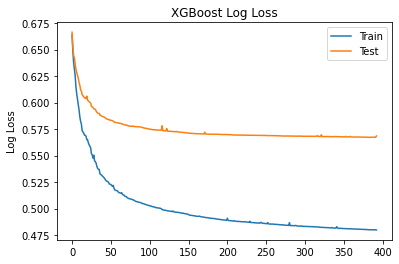

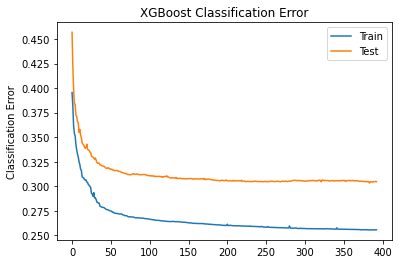

SMOTENC [OVERSAMPLING]
	XGBoost Over/Under-fitting
		Score: 0.6887867548244907
		Training time: 568.14 seconds
		Confusion Matrix
 col_0      0     1
state             
0      17774  6139
1       5440  7853
		Classification Report
               precision    recall  f1-score   support

           0       0.77      0.74      0.75     23913
           1       0.56      0.59      0.58     13293

    accuracy                           0.69     37206
   macro avg       0.66      0.67      0.66     37206
weighted avg       0.69      0.69      0.69     37206



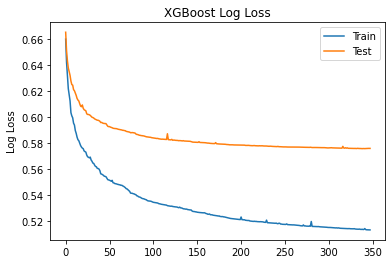

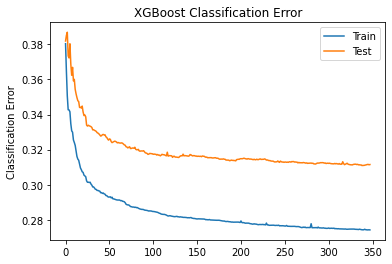

ADASYN [OVERSAMPLING]
	XGBoost Over/Under-fitting
		Score: 0.6942428640541848
		Training time: 383.53 seconds
		Confusion Matrix
 col_0      0     1
state             
0      18688  5225
1       6151  7142
		Classification Report
               precision    recall  f1-score   support

           0       0.75      0.78      0.77     23913
           1       0.58      0.54      0.56     13293

    accuracy                           0.69     37206
   macro avg       0.66      0.66      0.66     37206
weighted avg       0.69      0.69      0.69     37206



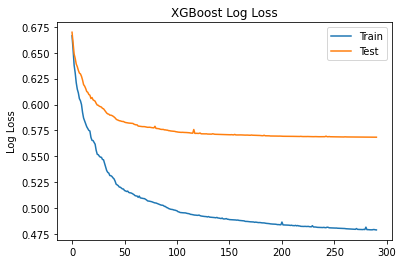

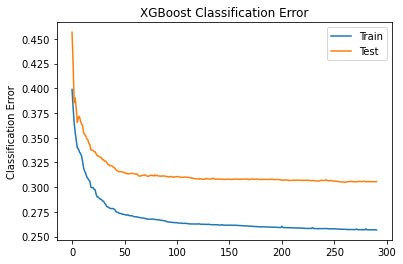

RandomUnderSampler [UNDERSAMPLING]
	XGBoost Over/Under-fitting
		Score: 0.6677686394667527
		Training time: 92.5 seconds
		Confusion Matrix
 col_0      0     1
state             
0      15536  8377
1       3984  9309
		Classification Report
               precision    recall  f1-score   support

           0       0.80      0.65      0.72     23913
           1       0.53      0.70      0.60     13293

    accuracy                           0.67     37206
   macro avg       0.66      0.67      0.66     37206
weighted avg       0.70      0.67      0.67     37206



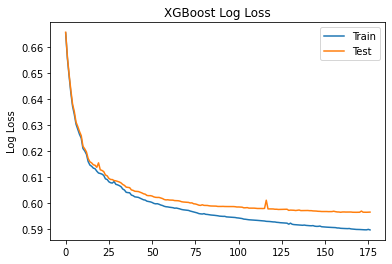

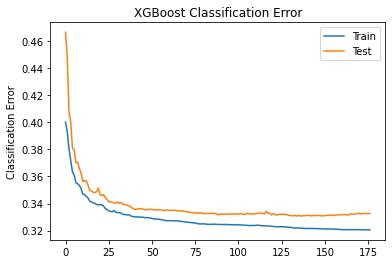

NearMiss v1 [UNDERSAMPLING]
	XGBoost Over/Under-fitting
		Score: 0.5417137020910606
		Training time: 0.9 seconds
		Confusion Matrix
 col_0      0      1
state              
0      11955  11958
1       5093   8200
		Classification Report
               precision    recall  f1-score   support

           0       0.70      0.50      0.58     23913
           1       0.41      0.62      0.49     13293

    accuracy                           0.54     37206
   macro avg       0.55      0.56      0.54     37206
weighted avg       0.60      0.54      0.55     37206



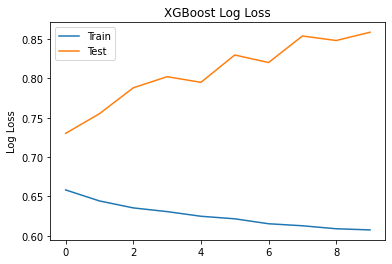

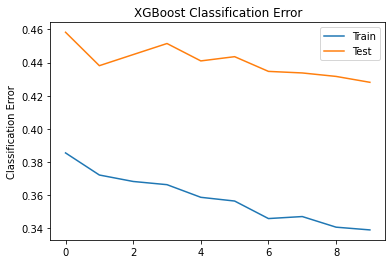

NearMiss v3 [UNDERSAMPLING]
	XGBoost Over/Under-fitting
		Score: 0.6647046175348063
		Training time: 20.39 seconds
		Confusion Matrix
 col_0      0     1
state             
0      16205  7708
1       4767  8526
		Classification Report
               precision    recall  f1-score   support

           0       0.77      0.68      0.72     23913
           1       0.53      0.64      0.58     13293

    accuracy                           0.66     37206
   macro avg       0.65      0.66      0.65     37206
weighted avg       0.68      0.66      0.67     37206



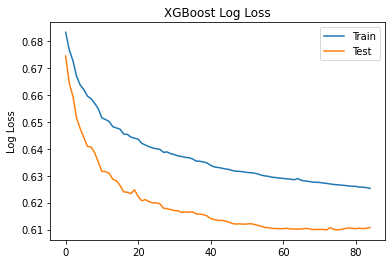

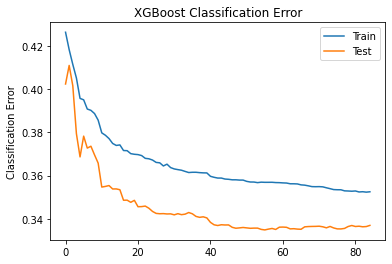

In [0]:
for key in train_data.keys():
  start = time.time()
  classifier_dart_xgb_fitting = xgb.XGBClassifier(verbosity=1, tree_method='gpu_hist', booster='dart', n_jobs=-1, seed=2137,
                                                learning_rate=.5, rate_drop=1e-3, sample_type='weighted', skip_drop=.1, n_estimators=500)
  print(key)

  xgb_eval_set = [(train_data[key]['x'], train_data[key]['y']), (test_data[key]['x'], test_data[key]['y'])]
  
  classifier_dart_xgb_fitting.fit(train_data[key]['x'], train_data[key]['y'], early_stopping_rounds=10, 
                             eval_set=xgb_eval_set, eval_metric=['error', 'logloss'], verbose=False)
  classifier_dart_xgb_fitting_predict = classifier_dart_xgb_fitting.predict(test_data[key]['x'])

  print(f"\tXGBoost Over/Under-fitting")
  print("\t\tScore:", classifier_dart_xgb_fitting.score(test_data[key]['x'], test_data[key]['y']))
  print(f"\t\tTraining time: {round(time.time() - start, 2)} seconds")
  print("\t\tConfusion Matrix\n", pd.crosstab(test_data[key]['y'], classifier_dart_xgb_fitting_predict))
  print("\t\tClassification Report\n", classification_report(test_data[key]['y'], classifier_dart_xgb_fitting_predict))

  # validation_0 - Train Set
  # validation_1 - Test Set

  # retrieve performance metrics
  results = classifier_dart_xgb_fitting.evals_result()
  epochs = len(results['validation_0']['error'])
  x_axis = range(0, epochs)

  # plot log loss
  fig, ax = plt.subplots()
  ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
  ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
  ax.legend()
  plt.ylabel('Log Loss')
  plt.title('XGBoost Log Loss')
  plt.show()

  # plot classification error
  fig, ax = plt.subplots()
  ax.plot(x_axis, results['validation_0']['error'], label='Train')
  ax.plot(x_axis, results['validation_1']['error'], label='Test')
  ax.legend()
  plt.ylabel('Classification Error')
  plt.title('XGBoost Classification Error')
  plt.show()

# Random Forest Classifier
Random Forest Classifier with default parameters, gives ~64% accuracy in 20s, so higher than SVC

In [0]:
for key in train_data.keys():
  random_forest_clf = RandomForestClassifier(verbose=1, n_jobs=-1, random_state=2137)
  print(key)
  train_model(random_forest_clf, "Random Forest", train_data[key]['x'], train_data[key]['y'], test_data[key]['x'], test_data[key]['y'])

SMOTE [OVERSAMPLING]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


	Random Forest


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


		Score: 0.6575552330269311
		Training time: 30.47 seconds
		Confusion Matrix
 col_0      0     1
state             
0      17915  5998
1       6743  6550
		Classification Report
               precision    recall  f1-score   support

           0       0.73      0.75      0.74     23913
           1       0.52      0.49      0.51     13293

    accuracy                           0.66     37206
   macro avg       0.62      0.62      0.62     37206
weighted avg       0.65      0.66      0.66     37206



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


SMOTENC [OVERSAMPLING]
	Random Forest


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


		Score: 0.6535505026071063
		Training time: 27.06 seconds
		Confusion Matrix
 col_0      0     1
state             
0      17346  6567
1       6323  6970
		Classification Report
               precision    recall  f1-score   support

           0       0.73      0.73      0.73     23913
           1       0.51      0.52      0.52     13293

    accuracy                           0.65     37206
   macro avg       0.62      0.62      0.62     37206
weighted avg       0.65      0.65      0.65     37206

ADASYN [OVERSAMPLING]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


	Random Forest


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


		Score: 0.6536042573778423
		Training time: 32.56 seconds
		Confusion Matrix
 col_0      0     1
state             
0      17727  6186
1       6702  6591
		Classification Report
               precision    recall  f1-score   support

           0       0.73      0.74      0.73     23913
           1       0.52      0.50      0.51     13293

    accuracy                           0.65     37206
   macro avg       0.62      0.62      0.62     37206
weighted avg       0.65      0.65      0.65     37206



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RandomUnderSampler [UNDERSAMPLING]
	Random Forest


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


		Score: 0.634978229317852
		Training time: 14.82 seconds
		Confusion Matrix
 col_0      0     1
state             
0      15075  8838
1       4743  8550
		Classification Report
               precision    recall  f1-score   support

           0       0.76      0.63      0.69     23913
           1       0.49      0.64      0.56     13293

    accuracy                           0.63     37206
   macro avg       0.63      0.64      0.62     37206
weighted avg       0.66      0.63      0.64     37206



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


NearMiss v1 [UNDERSAMPLING]
	Random Forest


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


		Score: 0.528221254636349
		Training time: 13.91 seconds
		Confusion Matrix
 col_0      0      1
state              
0      10970  12943
1       4610   8683
		Classification Report
               precision    recall  f1-score   support

           0       0.70      0.46      0.56     23913
           1       0.40      0.65      0.50     13293

    accuracy                           0.53     37206
   macro avg       0.55      0.56      0.53     37206
weighted avg       0.60      0.53      0.53     37206

NearMiss v3 [UNDERSAMPLING]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


	Random Forest


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s


		Score: 0.623313444068161
		Training time: 14.42 seconds
		Confusion Matrix
 col_0      0     1
state             
0      15264  8649
1       5366  7927
		Classification Report
               precision    recall  f1-score   support

           0       0.74      0.64      0.69     23913
           1       0.48      0.60      0.53     13293

    accuracy                           0.62     37206
   macro avg       0.61      0.62      0.61     37206
weighted avg       0.65      0.62      0.63     37206



[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


# Random Forest Search Best Parameters
Brute-force this classifier, to find the best parameters.

In [0]:
parameters_forest = {
    'max_depth': [3, 10],
    'min_samples_split': [2, 1e-7, 1e-3, .1],
    'min_samples_leaf': [1, 1e-7, 1e-3, .1],
    'oob_score': [True, False],
    'ccp_alpha': [0, 1],
}

# the best version
random_forest_clf = RandomForestClassifier(verbose=1, n_jobs=-1, random_state=2137)
grid_obj_forest = GridSearchCV(random_forest_clf, param_grid=parameters_forest, verbose=5, cv=4)
grid_obj_forest = grid_obj_forest.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_obj_forest.best_params_)
print("Best score for above parameters:", grid_obj_forest.best_score_)
print("Accuracy of Random Forest Model w/ best parameters:", grid_obj_forest.score(X_test, y_test))

# Random Forest Best Parameters
2% accuracy boost between default & best parameter models

Best parameters for Random Forest: {'ccp_alpha': 0, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 1e-07, 'oob_score': True}

Best score for above parameters: 0.6686757764793282

Accuracy of Random Forest Model w/ best parameters: 0.6693115308031135

# Deep Neural Network

In [0]:
tf.random.set_seed(2137)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall()])
model.fit(X_train, y_train, epochs=250, batch_size=1024, validation_data=(X_val, y_val))

loss, accuracy, recall = model.evaluate(X_test, y_test)
print("Loss for test data:", loss)
print("Accuracy for test data:", accuracy)

Epoch 1/250
377/377 [==============================] - 2s 5ms/step - loss: 0.6580 - accuracy: 0.6048 - recall: 0.6814 - val_loss: 0.6551 - val_accuracy: 0.5883 - val_recall: 0.6677
Epoch 2/250
377/377 [==============================] - 2s 4ms/step - loss: 0.6387 - accuracy: 0.6302 - recall: 0.7040 - val_loss: 0.6414 - val_accuracy: 0.6062 - val_recall: 0.6337
Epoch 3/250
377/377 [==============================] - 2s 4ms/step - loss: 0.6344 - accuracy: 0.6343 - recall: 0.6992 - val_loss: 0.6440 - val_accuracy: 0.6050 - val_recall: 0.6650
Epoch 4/250
377/377 [==============================] - 2s 4ms/step - loss: 0.6309 - accuracy: 0.6372 - recall: 0.6979 - val_loss: 0.6482 - val_accuracy: 0.5963 - val_recall: 0.7155
Epoch 5/250
377/377 [==============================] - 2s 4ms/step - loss: 0.6282 - accuracy: 0.6399 - recall: 0.6949 - val_loss: 0.6412 - val_accuracy: 0.6113 - val_recall: 0.6873
Epoch 6/250
377/377 [==============================] - 2s 4ms/step - loss: 0.6258 - accuracy: 0

# classifier_xgb.save_model('file_name.extension')
Above should be able to save model into file, then in AWS user-related:
### variable = xgb.XGBClassifier(...parameters...)
The best would be to save parameters as a JSON file and pass them as **kwargs to proper function.
### variable.load_model('file_name.extension')
Worth adding that saved model can be used for future training. No need to start learning from scratch. 